URL: https://www.kaggle.com/c/tensorflow-speech-recognition-challenge

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import sys
sys.path.append("../")
sys.path.append("../../src/")
from glob import glob
import re
from scipy.io import wavfile

import tensorflow as tf
from tensorflow.contrib import layers
from tensorflow.contrib import signal
# it's a magic function :)
from tensorflow.contrib.learn.python.learn.learn_io.generator_io import generator_input_fn
from tqdm import tqdm

/home/mageswarand/anaconda3/envs/tensorflow1.0/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/mageswarand/anaconda3/envs/tensorflow1.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
!ls ../../src/

experiments  log.txt  nlp  reinforcement_learning  sarvam  speech_recognition


In [4]:
!ls ../../data/tensorflow_speech_recoginition_challenge/train/audio

_background_noise_  dog    four   left	  off	 seven	 three	wow
bed		    down   go	  marvin  on	 sheila  tree	yes
bird		    eight  happy  nine	  one	 six	 two	zero
cat		    five   house  no	  right  stop	 up


In [5]:
DATA_DIR = "../../data/tensorflow_speech_recoginition_challenge/train/audio/"
OUT_DIR = "tensorflow_speech_recoginition_challenge/"
paths = glob(os.path.join(DATA_DIR, 'test/audio/*wav'))

filename = DATA_DIR+'/yes/0a7c2a8d_nohash_0.wav'

In [6]:
POSSIBLE_LABELS = 'yes no up down left right on off stop go unknown'.split()
id2name = {i: name for i, name in enumerate(POSSIBLE_LABELS)}
name2id = {name: i for i, name in id2name.items()}

In [7]:
from sarvam.eda.viz.audio import *

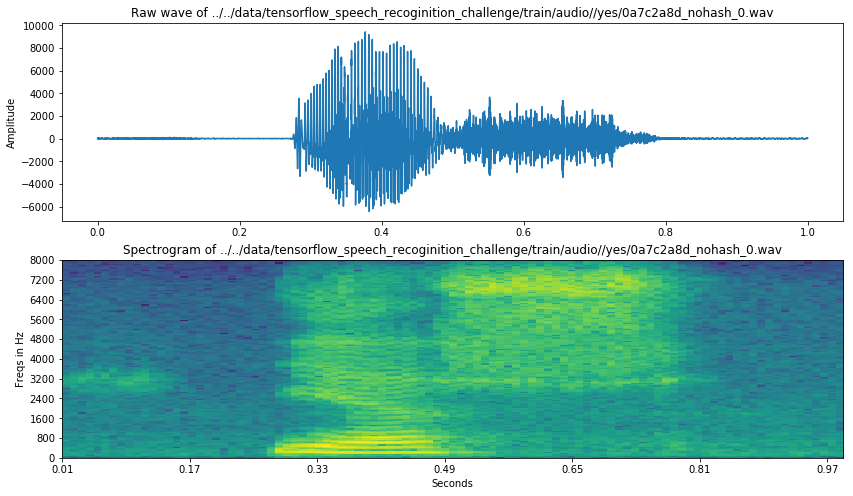

In [8]:
log_specgram(wave_file_path=DATA_DIR+'/yes/0a7c2a8d_nohash_0.wav')

audio.shape: (16000,)
log_S.shape: (64, 32)


/home/mageswarand/anaconda3/envs/tensorflow1.0/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning:

Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.



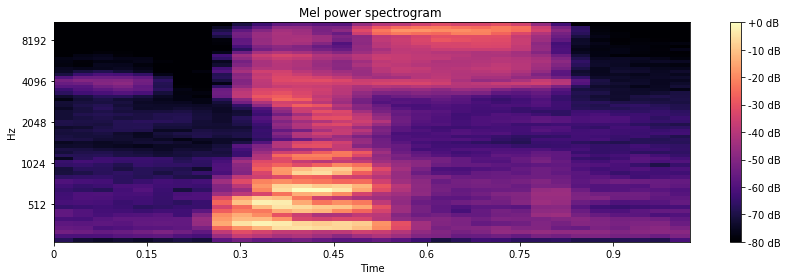

In [29]:
melspectrogram(wave_file_path=DATA_DIR+'/yes/0a7c2a8d_nohash_0.wav', is_delta = False)

log_S.shape: (128, 32)
delta2_mfcc.shape: (13, 32)


/home/mageswarand/anaconda3/envs/tensorflow1.0/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning:

Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.



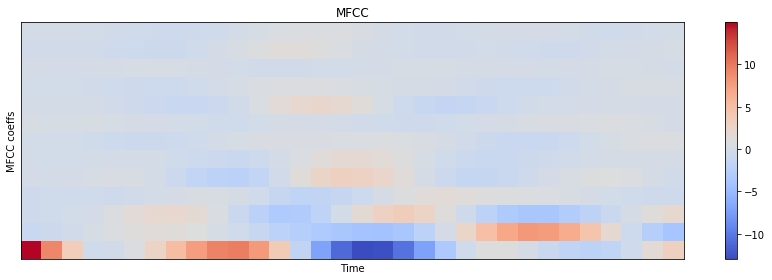

In [25]:
melspectrogram(wave_file_path=DATA_DIR+'/yes/0a7c2a8d_nohash_0.wav', is_delta = True)

In [11]:
specgram_3d(wave_file_path=DATA_DIR+'/yes/0a7c2a8d_nohash_0.wav')

### Silence Removal

In [12]:
sample_rate, audio = wavfile.read(DATA_DIR+'/yes/0a7c2a8d_nohash_0.wav')
ipd.Audio(audio, rate=sample_rate)

Some *VAD* (Voice Activity Detection) will be really useful here. Although the words are short, there is a lot of silence in them. A decent *VAD* can reduce training size a lot, accelerating training speed significantly.
Let's cut a bit of the file from the beginning and from the end. and listen to it again (based on a plot above, we take from 4000 to 13000):

In [13]:
audio_cut = audio[4000:13000]
ipd.Audio(audio_cut, rate=sample_rate)

We can agree that the entire word can be heard. It is impossible to cut all the files manually and do this basing on the simple plot. But you can use for example *webrtcvad* package to have a good *VAD*.

Let's plot it again, together with guessed alignment of* 'y' 'e' 's'* graphems

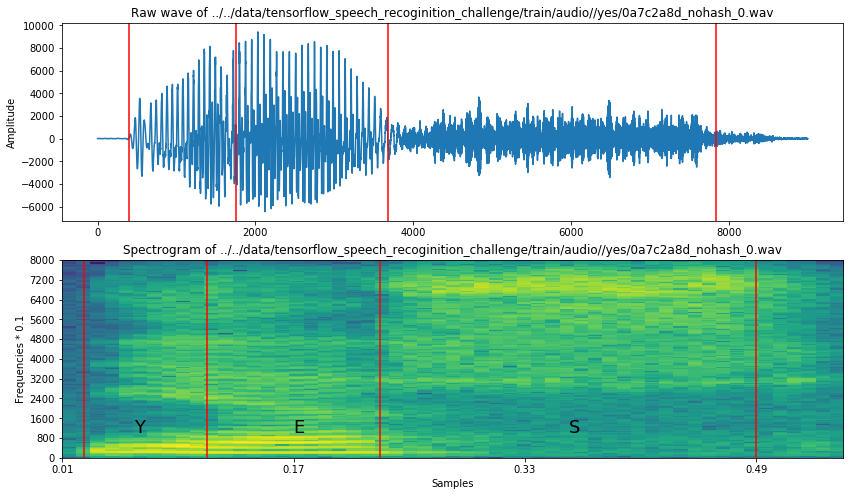

In [14]:
freqs, times, spectrogram_cut = get_spectrum(audio_cut, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(audio_cut)

ax2 = fig.add_subplot(212)
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Frequencies * 0.1')
ax2.set_xlabel('Samples')
ax2.imshow(spectrogram_cut.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.text(0.06, 1000, 'Y', fontsize=18)
ax2.text(0.17, 1000, 'E', fontsize=18)
ax2.text(0.36, 1000, 'S', fontsize=18)

xcoords = [0.025, 0.11, 0.23, 0.49]
for xc in xcoords:
    ax1.axvline(x=xc*16000, c='r')
    ax2.axvline(x=xc, c='r')

## Resampling - dimensionality reduction

Another way to reduce the dimensionality of our data is to resample recordings.

You can hear that the recording don't sound very natural, because they are sampled with 16k frequency, and we usually hear much more. However, [the most speech related frequencies are presented in smaller band](https://en.wikipedia.org/wiki/Voice_frequency). That's why you can still understand another person talking to the telephone, where GSM signal is sampled to 8000 Hz.

Summarizing, we could resample our dataset to 8k. We will discard some information that shouldn't be important, and we'll reduce size of the data.

We have to remember that it can be risky, because this is a competition, and sometimes very small difference in performance wins, so we don't want to lost anything. On the other hand, first experiments can be done much faster with smaller training size.

We'll need to calculate FFT (Fast Fourier Transform). Definition:

In [15]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])  # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    return xf, vals

Let's read some recording, resample it, and listen. We can also compare FFT, Notice, that there is almost no information above 4000 Hz in original signal.

In [16]:
filename = '/happy/0b09edd3_nohash_0.wav'
new_sample_rate = 8000

sample_rate, samples = wavfile.read(DATA_DIR + filename)
resampled = signal.resample(samples, int(new_sample_rate/sample_rate * samples.shape[0]))

In [17]:
ipd.Audio(samples, rate=sample_rate)

In [18]:
ipd.Audio(resampled, rate=new_sample_rate)

****Almost no difference!

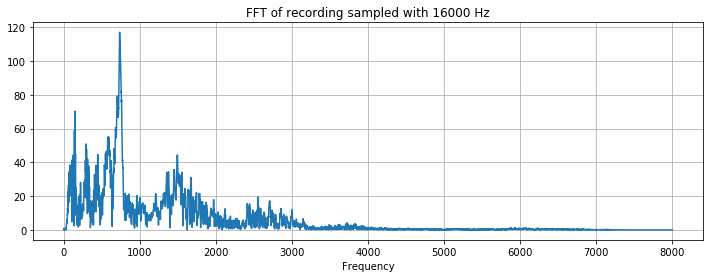

In [19]:
xf, vals = custom_fft(samples, sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

In [26]:
vals.shape

(4000,)

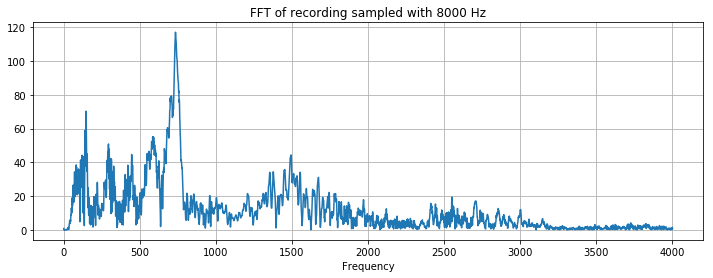

In [20]:
xf, vals = custom_fft(resampled, new_sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(new_sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

**This is how we reduced dataset size twice!